In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!mkdir -p ~/ .kaggle

In [4]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/

In [5]:
!chmod 600 ~/ .kaggle/kaggle.json

In [6]:
!kaggle datasets download -d humansintheloop/teeth-segmentation-on-dental-x-ray-images

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images
License(s): CC0-1.0
teeth-segmentation-on-dental-x-ray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip teeth-segmentation-on-dental-x-ray-images.zip

Archive:  teeth-segmentation-on-dental-x-ray-images.zip
replace Teeth Segmentation JSON/d2/ann/1.jpg.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [9]:
PRE = "/content/Teeth Segmentation PNG"

In [10]:
image_directory = PRE +'/d2/img/'
mask_directory = PRE +'/d2/masks_machine/'

In [11]:
SIZE = 256
image_dataset = []
mask_dataset = []

images = os.listdir(image_directory)
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory+str(i+1)+".jpg", 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        image = image.astype(np.float64)
        image_dataset.append(image)


mask2 = []
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+str(i+1)+".png", 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        image = image.astype(np.float64)
        mask_dataset.append(image)
        semantic_segmentation_mask = np.where(image != 0, 1, 0)
        mask2.append(np.array(semantic_segmentation_mask,dtype=np.float64))

In [12]:
image_dataset = np.array(image_dataset) /255.
image_dataset = np.expand_dims(image_dataset,3)

mask2_dataset = np.expand_dims(np.array(mask2),3)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask2_dataset, test_size = 0.20, random_state = 42)


In [14]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
CHANNELS = image_dataset.shape[3]

In [15]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
     smooth = 1.
     y_true_f = K.flatten(y_true)
     y_pred_f = K.flatten(y_pred)
     intersection = K.sum(y_true_f * y_pred_f)
     score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
     return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

'''
Here an implementation of the unnet model
This takes input that are already normalized.

Unet in few words:
- A contraction path
- A expansive path
- Skip-connections (concating means adding volume)
'''

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])
    model.summary()

    return model


In [17]:
model = simple_unet_model(IMG_HEIGHT,IMG_WIDTH,CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [18]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.keras', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),checkpointer ]

In [19]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks= callbacks,
                    shuffle=True)

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.2470
Epoch 1: val_loss improved from inf to 0.67772, saving model to model.keras
30/30 [==============================] - 36s 564ms/step - loss: 0.7097 - accuracy: 0.2470 - val_loss: 0.6777 - val_accuracy: 0.3076
Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.3913
Epoch 2: val_loss improved from 0.67772 to 0.64023, saving model to model.keras
30/30 [==============================] - 6s 195ms/step - loss: 0.6705 - accuracy: 0.3913 - val_loss: 0.6402 - val_accuracy: 0.4042
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.7284
Epoch 3: val_loss improved from 0.64023 to 0.29205, saving model to model.keras
30/30 [==============================] - 6s 194ms/step - loss: 0.5106 - accuracy: 0.7284 - val_loss: 0.2920 - val_accuracy: 0.8874
Epoch 4/100
30/30 [==============================] - ETA: 0s - loss: 0.2980 - accurac

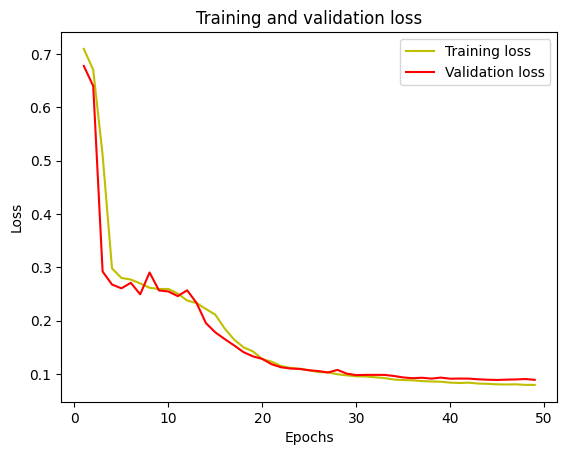

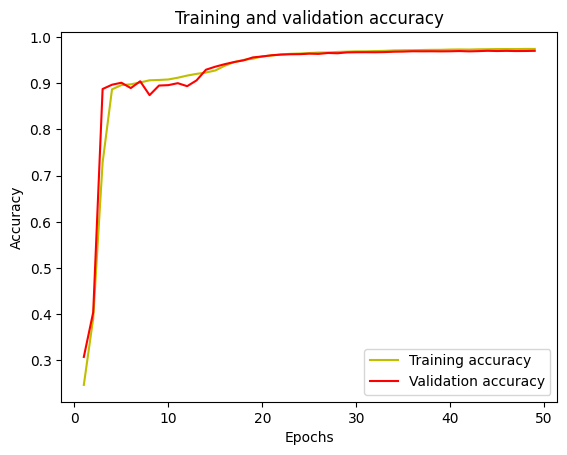

In [24]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
#IOU
# 1 if perfect overlapping, 0 otherwise
y_pred=model.predict(X_test)
y_pred_thresholded = (y_pred > 0.5).astype(int)

intersection = np.logical_and(y_pred_thresholded, y_test)
union = np.logical_or(y_pred_thresholded, y_test)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

4/4 [==============================] - 8s 1s/step
IoU socre is:  0.8373703683327374


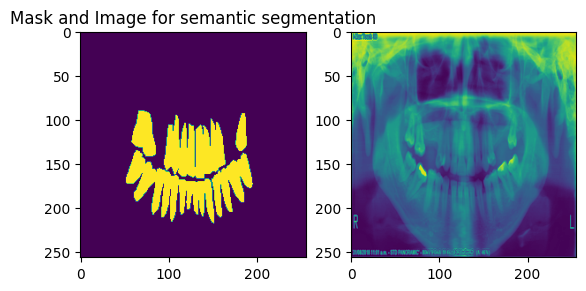

In [26]:
plt.subplot(1,2,1)
plt.title("Mask and Image for semantic segmentation")
plt.imshow(y_test[4])
plt.subplot(1,2,2)
plt.imshow(X_test[4])
plt.show()

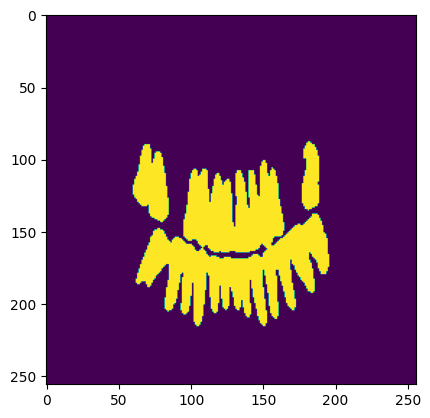

In [23]:
plt.imshow(y_pred_thresholded[4])
plt.show()